<img src = "https://scx2.b-cdn.net/gfx/news/hires/2022/ride-into-orbit-secure.jpg" style = "height:360px; width:900px; opacity: 1"/>

# <center> Satellite image classification with CNNs </center>

In this notebook, we present an application scenario for the classification of satellite images using a model based on a convolutional neural network (CNN). We structure the notebook as follows:

1. [Presentation of data](#1)
2. [Introduction of the model and training](#2)
3. [Analysis of the results](#3)

To start, we will import the libraries required for the project: alongside the conventional Python libraries and the deep learning library tensorflow, we will also call custom functions from our self developed library: `image_tools`.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
# Import from custom library since its located in another directory
import sys  
sys.path.insert(0, '../Scripts/')

from image_tools import generate_dataset, baseline_model, plot_history, model_accuracy, plot_confusion_matrix

Since image classification tasks are generally an expensive task in terms of computational resources, we will use the GPU unit in order to reduce the training time of the neural network. Let's first check if it's among the available resources: as we see, the GPU is activated and can be used. However, in case we are not interested in using it, with the code below, we can easily disable it.

In [15]:
print("List of physical devices: \n{}".format(tf.config.list_physical_devices()))

disable_gpu = False

if disable_gpu:
    tf.config.set_visible_device([], 'GPU')

List of physical devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a id="1"></a>
## Presentation of data

Once the technical adjustments have been made, we can proceed to present the data that will be used for the learning of the model. For this scenario, we will use the __[EuroSat](https://github.com/phelber/EuroSAT)__ project (RGB) dataset, which is made up of 27000 color satellite images (Sentinel-2) of size (64 x 64), corresponding to 10 distinct classes.
<br> The images have been randomly divided into 2 different directories in order to generate the training and test sets, in the following proportions: 90% of the data is for training and the remaining 10% for testing. In the training phase, 83% of the training data will be used exclusively to feed the model and the remaining 17% for validation, resulting in the distribution of 75% for the training, 15% for the validation and 10% for the testing. Regarding the data input for the model, each set consists of a sequence of batches made of 64 images. 

In [6]:
path_train = "../Data/EuroSat/2750/Training/"
path_test = "../Data/EuroSat/2750/Test/"


class_names = os.listdir(path_train)
print(f"Classes: \n{class_names}")

image_size = (64, 64)
batch_size = 64

train_data = generate_dataset(path_train, image_size, batch_size, 0.17, 'training', class_names)
val_data = generate_dataset(path_train, image_size, batch_size, 0.17, 'validation', class_names)

test_data = generate_dataset(path_test, image_size, batch_size, None, None, class_names)

print("Number of batches of the training set: {}".format(tf.data.experimental.cardinality(train_data).numpy()))
print("Number of batches of the validation set: {}".format(tf.data.experimental.cardinality(val_data).numpy()))
print("Number of batches of the test set: {}".format(tf.data.experimental.cardinality(test_data).numpy()))

Classes: 
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Found 24300 files belonging to 10 classes.
Using 20169 files for training.
Found 24300 files belonging to 10 classes.
Using 4131 files for validation.
Found 2700 files belonging to 10 classes.
Number of batches of the training set: 316
Number of batches of the validation set: 65
Number of batches of the test set: 43


Now let's have a look at the images and the associated categories. At first sight, some images seem to be similar despite of having been assigned to different classes. In particular, it can be quite complicated to find out the differences between the first image (AnnualCrop) and the seventh one (PermanentCrop). Thus, we shouldn't be surprised to find that the mistakes made by the model result from this type of occurrences. 

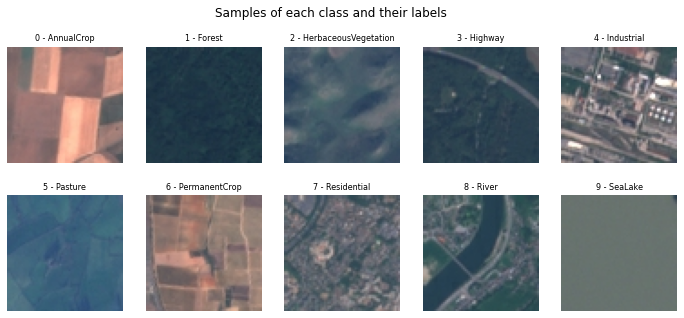

In [7]:
nrow, ncol = 2, 5

_, ax = plt.subplots(nrow, ncol, figsize=(12, 5))
plt.suptitle("Samples of each class and their labels")
for images, label in train_data.take(1):
    for i in range(10):
        for j in range(len(label)):
            if label[j] == i:
                ax[i//ncol, i%ncol].imshow(images[j].numpy().astype("uint8"))
                ax[i//ncol, i%ncol].set_title("{} - {}".format(label[j].numpy(), class_names[label[j].numpy()]), fontsize = 8)
                ax[i//ncol, i%ncol].axis("off")
                break
    break

The next part will focus on the convolutional neural network model, and since we will be using the GPU, we will benefit from prefetching the data to improve the performance of the GPU.

In [45]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(AUTOTUNE)
val_data = val_data.prefetch(AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)

<a id="2"></a>
## Introduction of the model and training

In this section we will introduce the model that will be used from now on for the learning and classification of images. 
<br> Image classification is one of the main areas covered in the field of artificial intelligence, meaning that there is a wide spectrum of different models and architectures with proven success. To avoid spending time attempting to design the perfect architecture, which is not our goal, we opted for a lighter version of an Xception type network, provided in the keras documentation.  This model will be the baseline and if the results are enough satisfactory (+90% accuracy), we won't consider a new model.

The construction of the model can be found in the `image_tools` module. All we have to do now is to define the parameters: the input is a color image (3 channels) of size (64 x 64) resulting in tensors of size (64 x 64 x 3), and the output is a vector of size 10 (number of categories) containing the probability of the image belonging to each of the categories. 

In [22]:
model = baseline_model(input_shape = image_size + (3,), num_classes = 10)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 128)  512         conv2d[0][0]                     
______________________________________________________________________________________________

Once we have defined the model parameters, it's time to set up the training parameters.
<br> One of the aspects of working with neural networks is the fact that we never know in advance how the model will behave to the data being fed to it, and this is why empirical strategies are used to find the best parameters (or the ones matching the expectations), and in particular to determine the ideal number of epochs during training.
<br> We used 30 epochs, a descending Adam gradient with a small learning rate, and achieved reasonably good results for our objectives. As for the loss function, the cross-entropy `SparseCategoricalCrossentropy` provides the best results for mutliclass classification problems.
<br> On the progression of the training, we can save the results of the training (loss and accuracy) that are stored in the history. Besides, we can also save the state of the model (weights and internal parameters) after completing every epoch, so we can choose the state with the highest precision, a very useful feature in case of overfitting, since the model doesn't have to be reset and retrained from scratch.

In [153]:
epochs = 30

hist_filename ='history.csv'

callbacks = [tf.keras.callbacks.CSVLogger('../Models/' + hist_filename, separator=",", append=True),
             tf.keras.callbacks.ModelCheckpoint("../Models/keras_checkpoints/save_at_{epoch}.keras")] #save weights for each epoch in a file

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3),
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"])

history = model.fit(train_data,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=val_data)

Epoch 1/30
316/316 [==============================] - 473s 1s/step - loss: 1.1744 - accuracy: 0.5984 - val_loss: 1.3670 - val_accuracy: 0.5405


C:\Users\Achraf\anaconda3\envs\cv-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
316/316 [==============================] - 594s 2s/step - loss: 0.6887 - accuracy: 0.7572 - val_loss: 4.0125 - val_accuracy: 0.3295
Epoch 3/30
316/316 [==============================] - 622s 2s/step - loss: 0.4877 - accuracy: 0.8350 - val_loss: 1.1290 - val_accuracy: 0.7289
Epoch 4/30
316/316 [==============================] - 622s 2s/step - loss: 0.3935 - accuracy: 0.8688 - val_loss: 0.7354 - val_accuracy: 0.7625
Epoch 5/30
316/316 [==============================] - 624s 2s/step - loss: 0.3141 - accuracy: 0.8942 - val_loss: 0.4549 - val_accuracy: 0.8504
Epoch 6/30
316/316 [==============================] - 617s 2s/step - loss: 0.2586 - accuracy: 0.9118 - val_loss: 6.6567 - val_accuracy: 0.3404
Epoch 7/30
316/316 [==============================] - 620s 2s/step - loss: 0.2420 - accuracy: 0.9193 - val_loss: 0.6470 - val_accuracy: 0.8078
Epoch 8/30
316/316 [==============================] - 622s 2s/step - loss: 0.2032 - accuracy: 0.9315 - val_loss: 0.4853 - val_accuracy: 0.8557

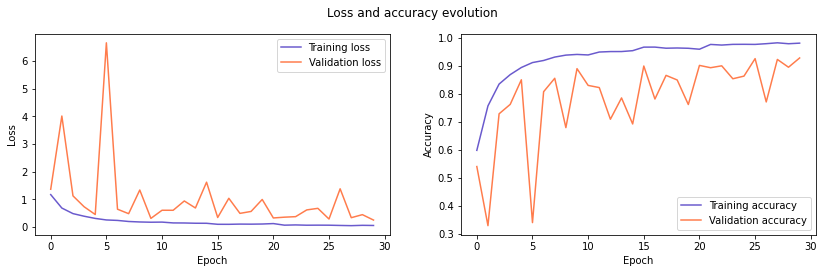

In [154]:
plot_history(history)

In terms of loss, the evolution of the loss for the validation set reveals an unstable model at the beginning of learning (< 10 epochs), that becomes more stable as the training progresses. On the contrary, the loss for the training set shows a smooth evolution. Simultaneously, there is a constant improvement in accuracy for the training set, whereas it's erratic for the validation set. For this measure, however, the slowdowns in performance are more pronounced.
<br> We should mention that from 20 epochs on, more than 80% of accuracy on the validation set is consistently achieved, which is very good news, especially with peaks of over 90% of accuracy. The training concludes at 30 epochs with a maximum accuracy of 92.8% achieved in the last epoch, meaning that loading the previously saved checkpoints will not be necessary. Considering the (relative) simplicity of the model, we are talking about a remarkably high accuracy.

In case one doesn't want to save the model states for every epoch, there is also the option to save the final model in its entirety, or just its weights.

In [2]:
#model.save_weights('./Models/baseline_model_30_epochs') # saving weights
#model.save('./Models/baseline_model') # saving model

In [8]:
#model = tf.keras.models.load_model('./Models/baseline_model')

<a id="3"></a>
## Analysis of the results

Now that the training has been completed, the positive results we observed during this phase have made us raise our expectations regarding the success of the model.
<br> Initially, we will preview the results visually, showing the first occurrence of every category from a random batch of the test set, and displaying their actual class as compared to the prediction made by the model.

Correct predictions 10 (100%)


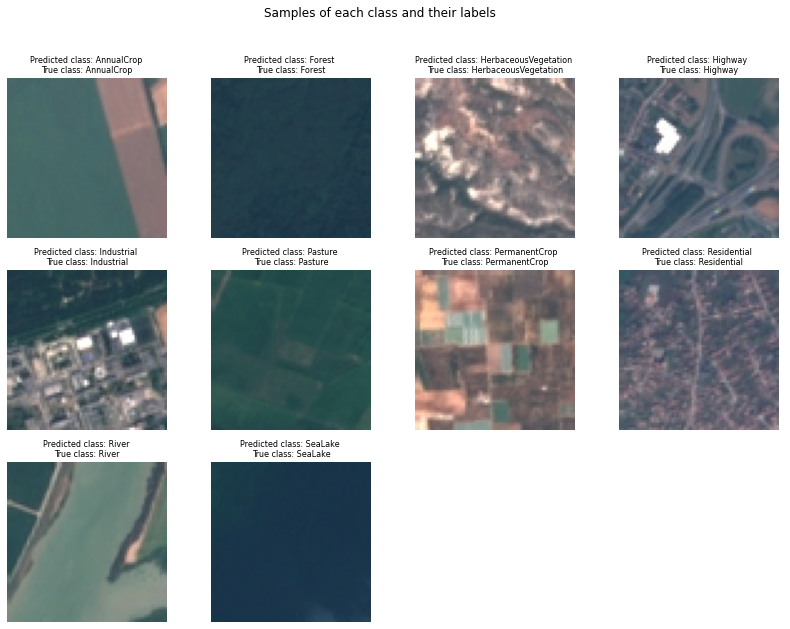

In [12]:
nrow, ncol = 3, 4

_, ax = plt.subplots(nrow, ncol, figsize=(14, 10))
for axis in ax.ravel()[-2:]:
    axis.set_axis_off()

plt.suptitle("Samples of each class and their labels")
for images, label in test_data.take(1):
    correct = 0
    for i in range(10):
        for j in range(len(label)):
            if label[j] == i:
                img_array = np.expand_dims(images[j].numpy(), 0)
                predicted = model.predict(img_array)
                predicted_class = class_names[np.argmax(predicted[0])]
                correct += 1 if predicted_class == class_names[label[j].numpy()] else 0
                ax[i//ncol, i%ncol].imshow(images[j].numpy().astype("uint8"))
                ax[i//ncol, i%ncol].set_title("Predicted class: {} \nTrue class: {}".format(predicted_class, \
                                        class_names[label[j].numpy()]), fontsize = 8)
                ax[i//ncol, i%ncol].axis("off")
                break
    break

print(f"Correct predictions {correct} ({correct*10}%)")

Based on the results reported here, the model manages to get all the images right, which is good news. Still, this method of control is merely to get an initial impression and doesn't indicate at all the actual efficiency of the model. We shall now conduct a comprehensive analysis on the entire test set, which we recall consists of 2,700 images. Furthermore, to identify on which categories the model is performing less well, we can look at the confusion matrix.

In [13]:
acc, m = model_accuracy(model, test_data.unbatch())

Accuracy: 0.927


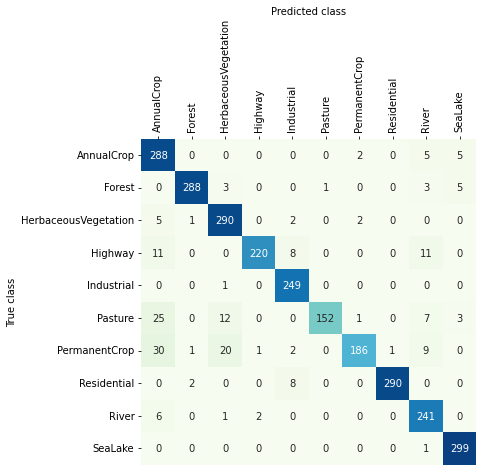

In [14]:
plot_confusion_matrix(m, class_names, fmt = '.3g')

Now that we have completed the runs on the test set, we confirm that the model performs remarkably well and maintains the accuracy level at 92.7% (compared to the 92.8% achieved during training). The model consistently achieves high accuracy levels (over 96%) in 7 of the 10 classes. Nevertheless, in the remaining three categories, prediction success rates are below expectations: Highway, and most notably Pasture and PermanentCrop respectively, with accuracy rates of 88%, 76% and 74%. 
In the latter two cases, a substantial proportion of the incorrect predictions were associated to AnnualCrop and HerbaceousVegetation categories, which is not surprising given the composition of the set. Meanwhile, failed predictions in the Highway category were labeled under the AnnualCrop, Industrial and River categories.

For a better understanding of such misidentifications, we will display some of the wrongly labeled images. 

In [46]:
input_, target_ = np.array(list(map(lambda x: [x[0], x[1].numpy()], test_data.unbatch())), dtype = object).T
predictions = np.array([np.argmax(model.predict(np.expand_dims(input_[i], 0))) for i in range(len(input_))])

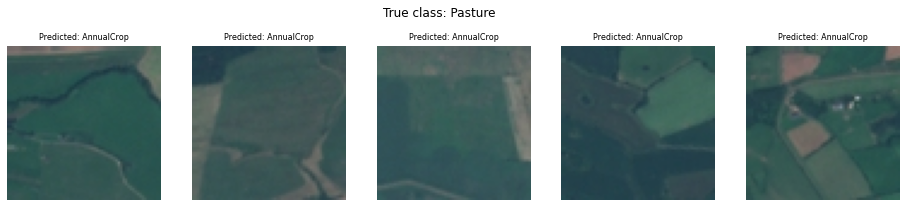

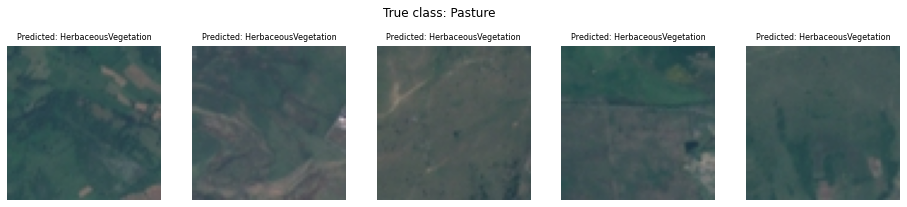

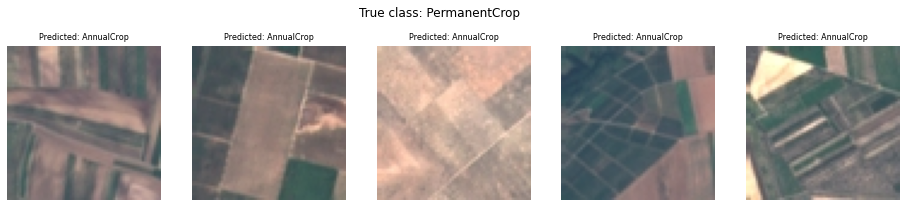

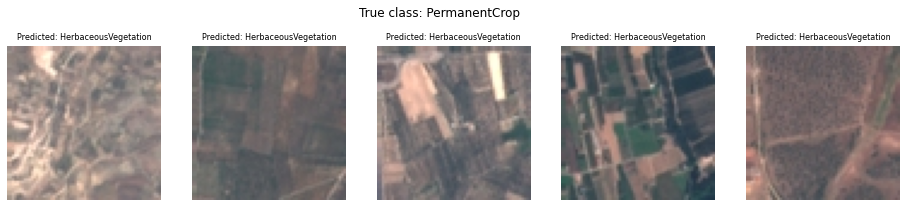

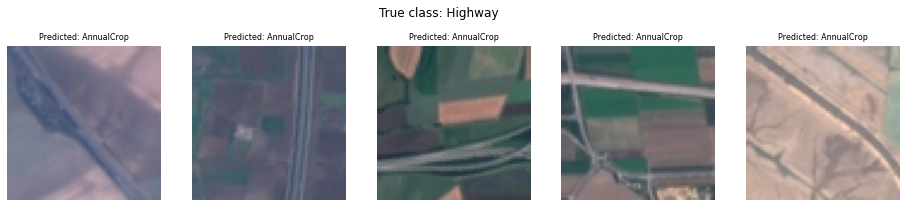

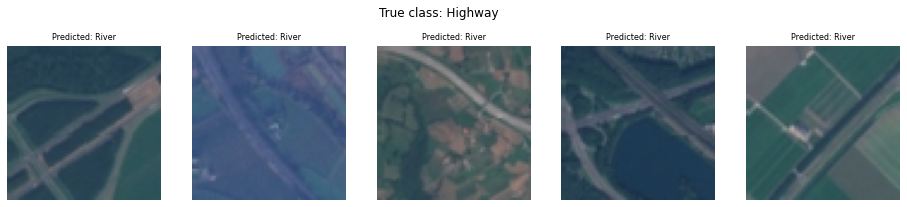

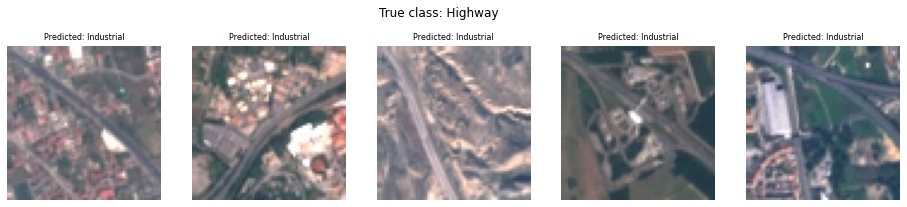

In [48]:
dic_classes = {name: i for i, name in enumerate(class_names)}
true_class = ['Pasture', 'Pasture', 'PermanentCrop', 'PermanentCrop', 'Highway', 'Highway', 'Highway']
predicted_class = ['AnnualCrop', 'HerbaceousVegetation', 'AnnualCrop', 'HerbaceousVegetation', 'AnnualCrop', \
                                                                                'River', 'Industrial']

for true, pred in zip(true_class, predicted_class):
    plt.figure(figsize = (16, 4))
    j = 0
    
    for img, t, p in zip(input_, target_, predictions):
        if t == dic_classes[true] and p == dic_classes[pred] and j<5:
            plt.subplot(1, 5, j+1)
            plt.title(f"Predicted: {pred}", fontsize = 8)
            plt.imshow(img.numpy().astype("uint8"))
            plt.axis('off')
            j+= 1
    
    plt.suptitle(f"True class: {true}")
    plt.subplots_adjust(top=1.03)

    plt.show()
          

After analyzing the images, we can understand that mistakes can be made in some situations, since there are ambiguous images that can belong to either of the two categories (the actual one and the attributed one), for instance, Highway with AnnualCrop, or Pasture with HerbaceousVegetation. For others, such as highway and river, depend on the context, and even though it's possible to perceive the difference visually ( with some difficulty sometimes), saturation levels and contrast do appear to have an impact on the predictions. However, it's fair to say that Highway to Industrial labelings appear to be grosser mistakes, since the majority of the cases presented here are not particularly complex to be distinguished. 